<a href="https://colab.research.google.com/github/illusion173/CS555UAV/blob/main/CS555Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CS555 Final Project
Project Title: Identifying Airborne Drones Using YOLO

Group Number: 4

Group Members: Caleb Hall, Clay Pate, Jeremiah Webb
##### Description: This project utilizes what we have learned in the CS555 course to create and train a ML model on a given dataset. Our group chose a dataset consisting of drone images along with text descriptions (4 coordinates) detailing where in the image the drone is located. This file contains all of the project code. In this file, the drone dataset is loaded in. Then, we detail code for drawing a box on the image. This helps us to quickly determine what the Ground Truth (GT) of a drone image is, and compare it to our prediction. We then train a YOLO model to predict where the drone is located. Lastly, we show examples of the model's prediction and evaluate its correctness by showing the boxes of its prediction. The blue box represents the GT, and the green box represents the model's prediction.

Caleb Hall worked on model optimization and tuning. Clay Pate worked on the code to draw boxes and model evaluation/tuning. Jeremiah Webb worked on loading and cleaning the data, as well as initial setup of the model training.

Note: To enable GPU usage and lower training times, edit the runtime enviroment by using the Google colab settings Runtime > Change runtime type > Hardware accelerator > T4 GPU

In [ ]:
# Necessary Commands to run before import
%pip install ultralytics
!pip install -U ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import needed forms
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings
import zipfile
import ultralytics
import shutil
from ultralytics import YOLO, settings
import yaml
import random

**GOOGLE DRIVE MOUNTING/UNZIPPING OF DATASET**

In [ ]:
# If not using Google Colab, comment out this cell

# DO NOT TOUCH PLEASE, loc of your zip file should match this
# the zip should be in the root of your google drive.

from google.colab import drive
GOOGLE_DRIVE_DATA_DIR_PATH = "/content/drive/"
drive.mount(GOOGLE_DRIVE_DATA_DIR_PATH, force_remount=True)
%cd /content/drive/MyDrive/
# Unzip the file into /tmp using -d, shouldn't take too long <1 min
!unzip -q "uav_datasets.zip" -d /tmp


'\nfrom google.colab import drive\nGOOGLE_DRIVE_DATA_DIR_PATH = "/content/drive/"\ndrive.mount(GOOGLE_DRIVE_DATA_DIR_PATH, force_remount=True)\n%cd /content/drive/MyDrive/\n# Unzip the file into /tmp using -d, shouldn\'t take too long <1 min\n!unzip -q "uav_datasets.zip" -d /tmp\n'

In [ ]:
# If running locally, uncomment this section
# Place downloaded zip file in root of storage device
'''
zip_location = r"C:\uav_datasets.zip"
destination = r"C:\tmp"   # where the ZIP’s contents will live

if not os.path.isdir(destination):
    with zipfile.ZipFile(zip_location, 'r') as z:
        z.extractall(destination)
else:
    print(f"File already exists")
'''

File already exists


**DATA INGESTION/ORGANIZATION**

In [ ]:
# KEEP NOTE THAT THE DIRECTORIES MADE IN THIS CELL ARE IN THE /tmp dir and WILL BE DELETED
YOLO_DATASET_FOLDER = "/tmp/drone_dataset_yolo/dataset_txt/" # This dir made in the above unzip cell
TRAIN_IMAGES_FOLDER = "/tmp/train/images"
TRAIN_LABELS_FOLDER = "/tmp/train/labels"
VAL_IMAGES_FOLDER = "/tmp/val/images"
VAL_LABELS_FOLDER = "/tmp/val/labels"
os.makedirs(TRAIN_IMAGES_FOLDER, exist_ok=True)
os.makedirs(TRAIN_LABELS_FOLDER, exist_ok=True)
os.makedirs(VAL_IMAGES_FOLDER, exist_ok=True)
os.makedirs(VAL_LABELS_FOLDER, exist_ok=True)

In [ ]:
# Creating necessary lists for organizing the files
images = []
labels = []

# Collect image and label file paths from the dataset folder
for file_name in os.listdir(YOLO_DATASET_FOLDER):
    if file_name.endswith((".jpg", ".png")):  # Assuming images are .jpg or .png
        base_name = os.path.splitext(file_name)[0]
        label_file = base_name + ".txt"  # Assuming labels are in YOLO format (.txt)

        # Check if the corresponding label file exists
        if os.path.exists(os.path.join(YOLO_DATASET_FOLDER, label_file)):
            images.append(file_name)
            labels.append(label_file)

In [ ]:
# Split the data into training and validation sets 80% train, 20% val
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [ ]:
# Define helper function to organize the files into appropriate train and value folders
def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

In [ ]:
# Move the training images and labels to the train folder
move_files(train_images, YOLO_DATASET_FOLDER, TRAIN_IMAGES_FOLDER)
move_files(train_labels, YOLO_DATASET_FOLDER, TRAIN_LABELS_FOLDER)

# Move the validation images and labels to the val folder
move_files(val_images, YOLO_DATASET_FOLDER, VAL_IMAGES_FOLDER)
move_files(val_labels, YOLO_DATASET_FOLDER, VAL_LABELS_FOLDER)

Showing Off Original Labels

In [ ]:
def draw_yolo_box(image_path, label_path, color=(0, 0, 255), thickness=2):
    """Reads an image and its YOLO label file, draws the bounding box."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None
    h, w = image.shape[:2]
    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                print(f"Warning: Label file {label_path} is empty.")
                return image

            parts = line.split()

            if len(parts) == 5:
                class_id, x_center, y_center, width_rel, height_rel = map(float, parts)


                x_center_abs = x_center * w
                y_center_abs = y_center * h
                width_abs = width_rel * w
                height_abs = height_rel * h


                x_min = int(x_center_abs - (width_abs / 2))
                y_min = int(y_center_abs - (height_abs / 2))
                x_max = int(x_center_abs + (width_abs / 2))
                y_max = int(y_center_abs + (height_abs / 2))


                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(w - 1, x_max)
                y_max = min(h - 1, y_max)


                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
            else:
                print(f"Warning: Invalid format in label file {label_path}. Expected 5 values, got {len(parts)}")

    except FileNotFoundError:
        print(f"Warning: Label file {label_path} not found.")

        return image
    except Exception as e:
        print(f"Error processing label file {label_path}: {e}")
        return image

    return image

Showing example: 0331.jpg


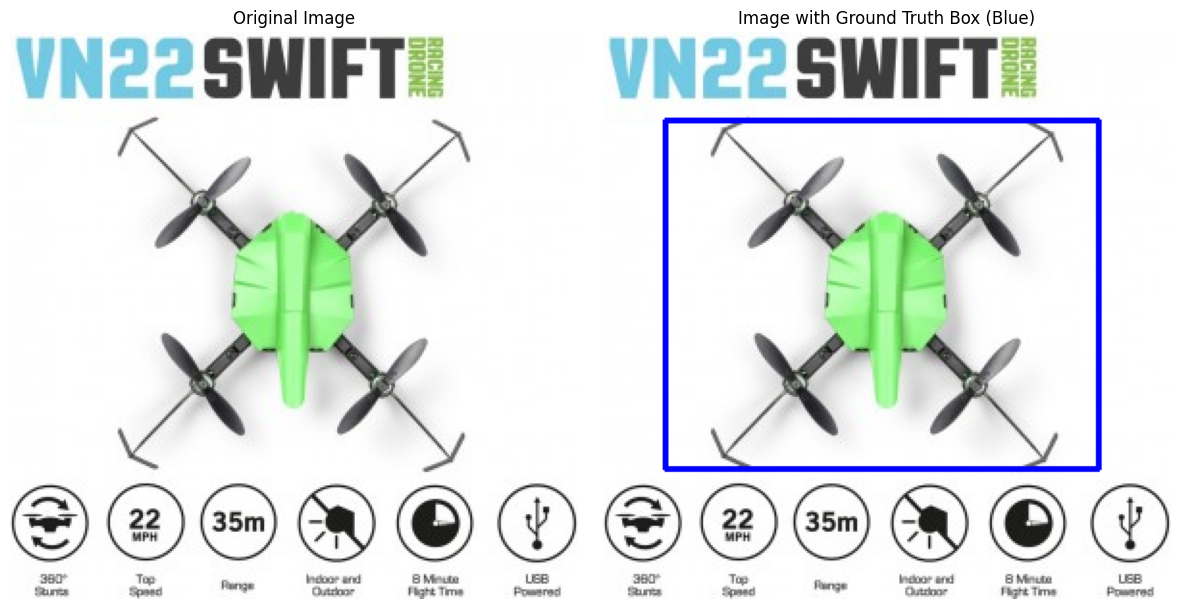

In [ ]:
if val_images:
    example_idx = random.randint(0, len(val_images) - 1)
    example_image_name = val_images[example_idx]
    example_label_name = val_labels[example_idx]

    example_image_path = os.path.join(VAL_IMAGES_FOLDER, example_image_name)
    example_label_path = os.path.join(VAL_LABELS_FOLDER, example_label_name)

    print(f"Showing example: {example_image_name}")

    original_image = cv2.imread(example_image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image_with_box = draw_yolo_box(example_image_path, example_label_path, color=(255, 0, 0), thickness=2)
    if image_with_box is not None:
        image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image_rgb)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(image_with_box_rgb)
        plt.title("Image with Ground Truth Box (Blue)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("could not display example image")

else:
    print("no validation images found")

Model Creation

In [ ]:
yolo_config = {
    "train": os.path.join("/tmp", "train/images"),
    "val": os.path.join("/tmp", "val/images"),
    "nc": 1,
    "names": ["drone"]
}
# THIS FILE WILL BE DELETED, REQUIRED TO BE RAN EACH TIME.
# Define the output YAML file path
yaml_file = "/tmp/yolo_dataset.yaml"

# Write the YOLO dataset information to the YAML file
with open(yaml_file, "w") as file:
    yaml.dump(yolo_config, file)

In [ ]:
# Physical Creation of the yolo model
# We don't need wandb
settings.update({"wandb": False})

# Load a COCO-pretrained YOLO model
yolo_model = YOLO("yolo11n.pt")
yolo_model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

Model Training

In [ ]:
results = yolo_model.train(
    data = yaml_file,
    epochs = 100, # We can default to 100 for now then on patience setting will tell it to stop after 10 epochs if it isn't getting any better
    imgsz = 640,
    batch = -1,
    optimizer = "AdamW",
    patience = 10
)
# Docs here
# https://docs.ultralytics.com/modes/train/

Ultralytics 8.3.111  Python-3.12.2 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=/tmp/yolo_dataset.yaml, epochs=100, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning C:\tmp\train\labels... 1087 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1087/1087 [00:01<00:00, 

train: WARNING  C:\tmp\train\images\pic_722.jpg: corrupt JPEG restored and saved
train: New cache created: C:\tmp\train\labels.cache


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU) 6.00G total, 0.10G reserved, 0.06G allocated, 5.84G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590035       6.441         0.461          43.3         227.8        (1, 3, 640, 640)                    list
     2590035       12.88         0.610         29.98         146.3        (2, 3, 640, 640)                    list
     2590035       25.76         0.904         49.97         129.9        (4, 3, 640, 640)                    list
     2590035       51.52         1.533         39.98           129        (8, 3, 640, 640)                    list
     2590035         103         2.735         65.41         144.6       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 24 for CUDA:0 4.11G/6.00G (69%) 
train: Fast image access  (ping: 0.00.0 ms, read:

train: Scanning C:\tmp\train\labels.cache... 1087 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1087/1087 [00:00<?

train: WARNING  C:\tmp\train\images\pic_722.jpg: corrupt JPEG restored and saved


val: Fast image access  (ping: 0.20.1 ms, read: 8.79.5 MB/s, size: 166.3 KB)


val: Scanning C:\tmp\val\labels.cache... 272 images, 0 backgrounds, 0 corrupt: 100%|██████████| 272/272 [00:00<?, ?it/s


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005625000000000001), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.2G        1.9      2.301      2.005         19        640: 100%|██████████| 46/46 [00:14<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296    0.00214      0.301     0.0013   0.000414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.21G      1.893      1.926      2.021         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296   0.000494      0.132   0.000278    8.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.19G      1.932      1.937      2.017         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296     0.0157      0.642     0.0116    0.00414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.21G      1.805      1.763      1.933         14        640: 100%|██████████| 46/46 [00:12<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.108     0.0541     0.0281    0.00647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.2G      1.766      1.676      1.872         24        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.374      0.389      0.287     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.21G      1.737       1.64      1.851         18        640: 100%|██████████| 46/46 [00:12<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.574        0.5      0.538      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.2G      1.683      1.568       1.79         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.422      0.169      0.207      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.19G      1.668      1.539      1.769         24        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.267      0.277      0.196     0.0752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.2G      1.642      1.511       1.75         30        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.162      0.287      0.122     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.21G      1.577      1.445      1.701         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.555       0.49      0.471      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.18G      1.579      1.424      1.712         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296       0.79      0.698      0.765      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.21G      1.595      1.411      1.708         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296        0.5      0.493      0.491      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.21G      1.512       1.35      1.642         22        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.733      0.625      0.692      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.2G      1.521      1.321      1.665         15        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.702      0.639      0.729      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.21G      1.509      1.271      1.624         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.741      0.598      0.698      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.25G      1.499      1.296      1.643         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.737      0.652      0.729      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.18G      1.475      1.259      1.616         11        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.816      0.682      0.762      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.23G      1.477      1.244      1.608         21        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.827      0.775      0.831      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.21G      1.471      1.245      1.617         19        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.812      0.682      0.745      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.22G      1.479      1.247      1.602         21        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.733      0.764      0.798      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.21G      1.447      1.201      1.598         12        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.803      0.709      0.791      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       3.2G      1.436       1.17      1.584         27        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.649      0.544      0.569      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.21G      1.442      1.185      1.584         13        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.829      0.735      0.808      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.2G      1.403      1.181      1.545         23        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.791      0.679      0.763      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.22G      1.428      1.169      1.546         30        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.736      0.693      0.708      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.19G       1.39      1.103      1.519         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.795      0.804      0.816      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       3.2G       1.39      1.115      1.532         22        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.852      0.797      0.868       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.22G      1.374      1.079      1.529         24        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.914      0.736      0.869      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.18G      1.366      1.072      1.502         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.711      0.662      0.695      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.21G      1.382      1.059      1.515         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.878      0.807      0.877      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.21G      1.333      1.032      1.479         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.838      0.838      0.868      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.19G      1.339      1.029       1.48         22        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.862      0.797      0.865      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.28G      1.336      1.009      1.487         19        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.885      0.797      0.889      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.2G      1.341      1.013      1.488         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.846      0.801      0.843      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.22G      1.364      1.042      1.492         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296      0.834      0.804       0.85      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.21G      1.324     0.9986      1.472         20        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.865      0.814      0.862       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.21G      1.303      0.982      1.472         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.872      0.804      0.872      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.25G      1.308     0.9682      1.455         16        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.869      0.821      0.867      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.21G      1.322     0.9709      1.455         17        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0

                   all        272        296       0.86      0.812      0.861      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.21G      1.281     0.9753      1.442         18        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.913      0.777      0.864      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.18G      1.262     0.9144      1.421         14        640: 100%|██████████| 46/46 [00:13<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<0

                   all        272        296      0.833      0.828      0.869      0.548
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.182 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.5MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.111  Python-3.12.2 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<0


                   all        272        296      0.838      0.838      0.868      0.556
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\detect\train3


Results

results saved to: runs\detect\train3
displaying training metrics plot (results.png):


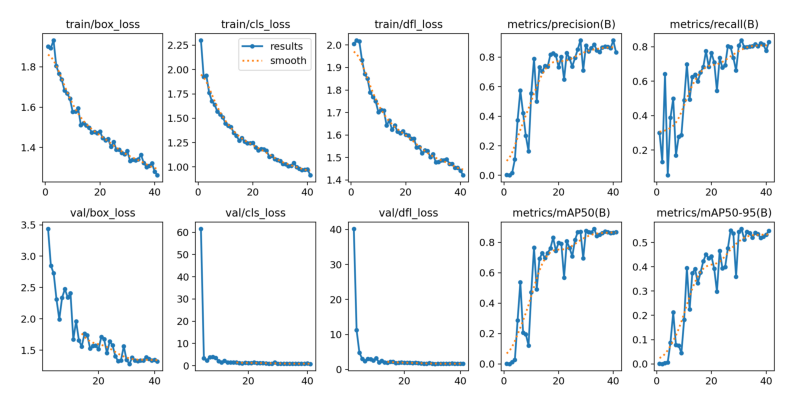

Showing CM:


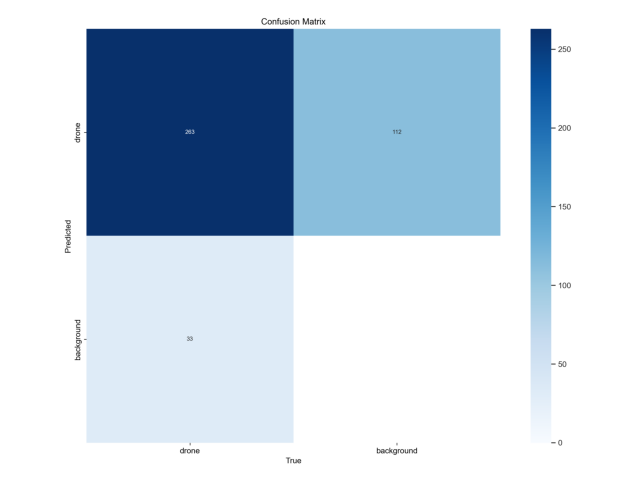

In [ ]:
results_plot_path = os.path.join(results.save_dir, "results.png")
confusion_matrix_path = os.path.join(results.save_dir, "confusion_matrix.png")

print(f"results saved to: {results.save_dir}")

if os.path.exists(results_plot_path):
    print("displaying training metrics plot (results.png):")
    results_img = Image.open(results_plot_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(results_img)
    plt.axis('off')
    plt.show()
else:
    print(f"doesnt exist: {results_plot_path}")

if os.path.exists(confusion_matrix_path):
    print("Showing CM:")
    cm_img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm_img)
    plt.axis('off')
    plt.show()
else:
    print(f"CM not found {confusion_matrix_path}")


Loading best model from runs\detect\train3\weights/best.pt

0: 640x640 1 drone, 23.3ms
1: 640x640 3 drones, 23.3ms
2: 640x640 1 drone, 23.3ms
3: 640x640 1 drone, 23.3ms
4: 640x640 1 drone, 23.3ms
5: 640x640 1 drone, 23.3ms
Speed: 3.2ms preprocess, 23.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Displaying prediction results (Ground Truth: Red, Prediction: Green):


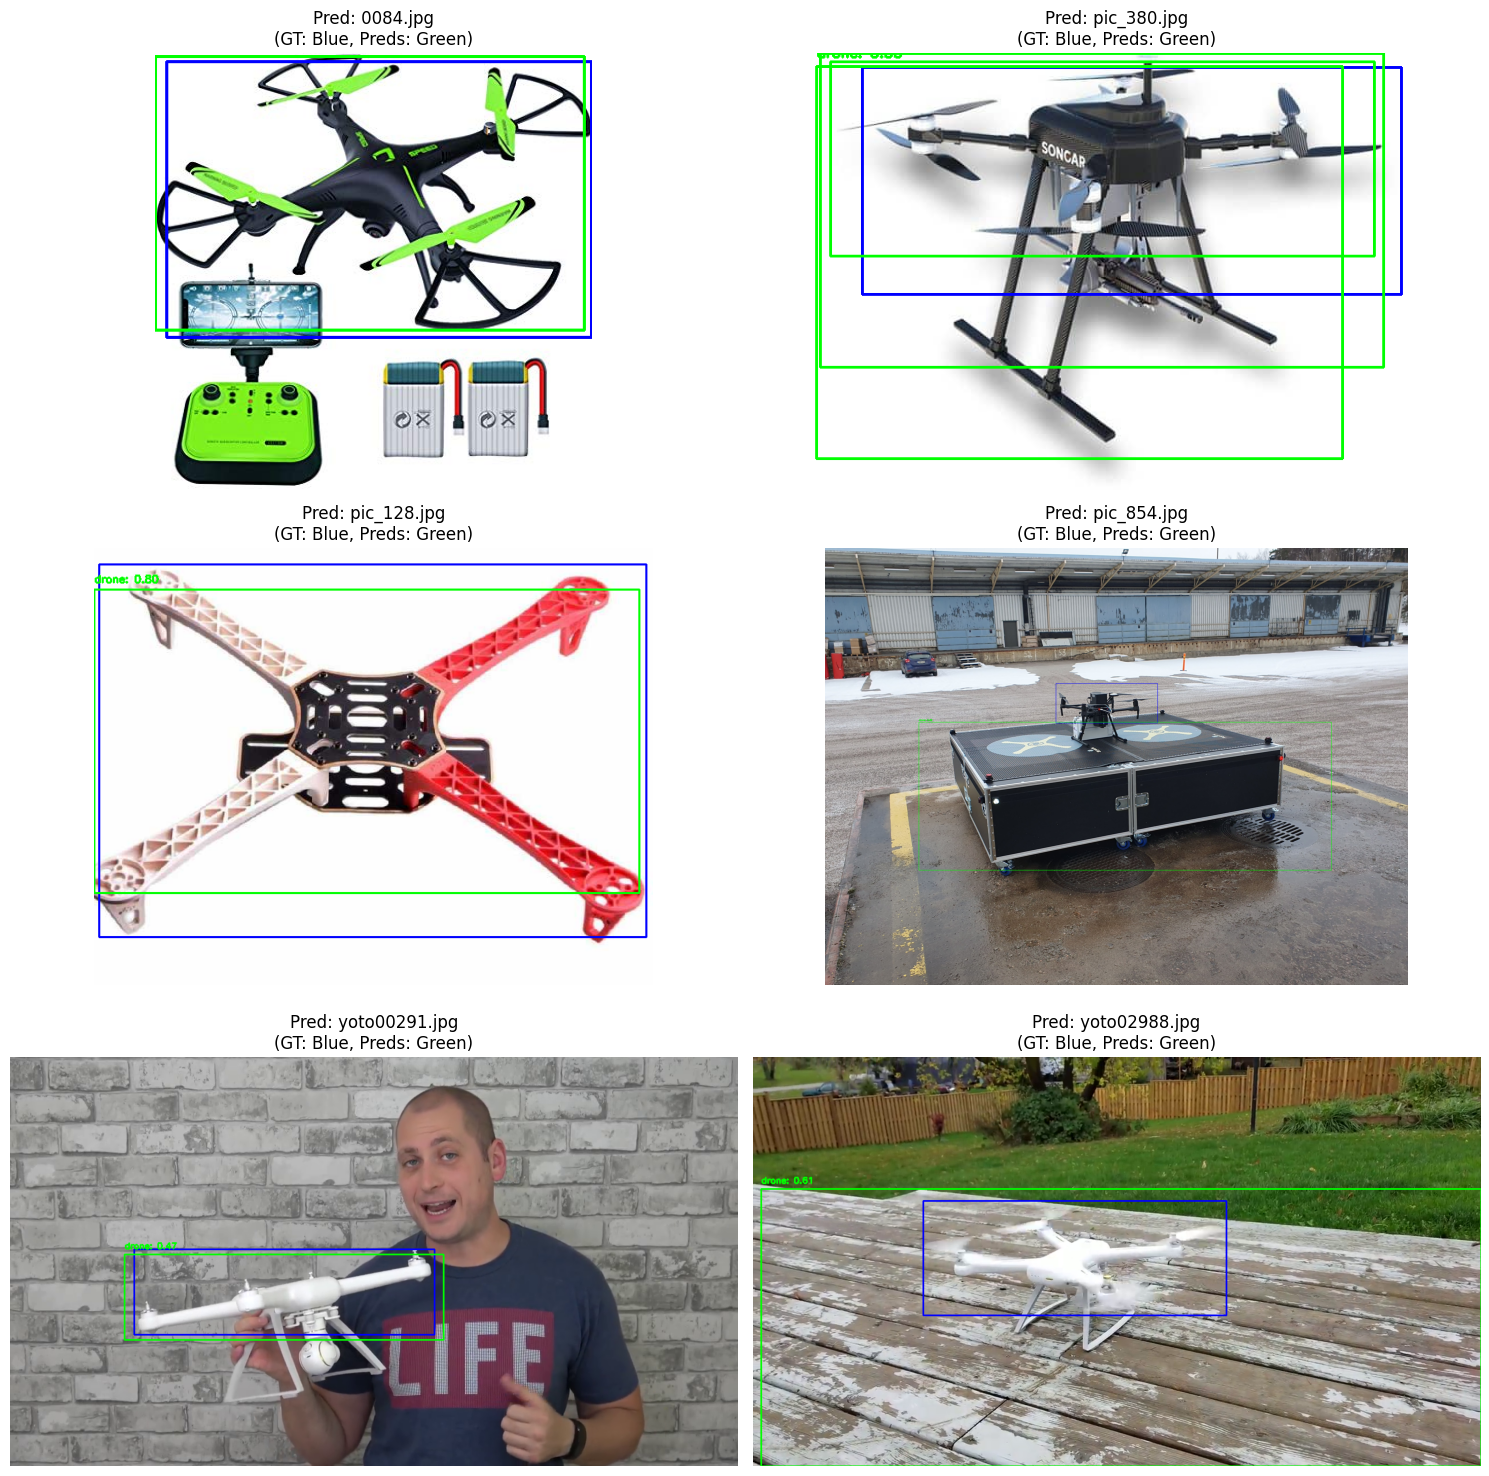

In [ ]:
best_model_path = os.path.join(results.save_dir, 'weights/best.pt')

print(f"Loading best model from {best_model_path}")
trained_model = YOLO(best_model_path)

validation_image_paths = [os.path.join(VAL_IMAGES_FOLDER, img) for img in val_images]

num_examples = 6
if len(validation_image_paths) >= num_examples:
    example_paths = random.sample(validation_image_paths, num_examples)
else:
    example_paths = validation_image_paths

predictions = trained_model.predict(example_paths, conf=0.25)

print("Displaying prediction results (Ground Truth: Red, Prediction: Green):")
plt.figure(figsize=(15, num_examples * 5 // 2))
plot_index = 1

for i, pred in enumerate(predictions):
    img_path = example_paths[i]
    base_name = os.path.basename(img_path)
    label_name = os.path.splitext(base_name)[0] + ".txt"
    label_path = os.path.join(VAL_LABELS_FOLDER, label_name)

    img_with_gt = draw_yolo_box(img_path, label_path, color=(255, 0, 0), thickness=2)

    if img_with_gt is None: continue

    img_with_preds = img_with_gt.copy()
    boxes = pred.boxes

    if boxes is not None and len(boxes) > 0:
        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            cv2.rectangle(img_with_preds, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
            label_text = f"{trained_model.names[cls]}: {conf:.2f}"
            cv2.putText(img_with_preds, label_text, (xyxy[0], xyxy[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"No predictions for {base_name} (or below confidence threshold)")


    plt.subplot( (num_examples + 1) // 2, 2, plot_index)
    plt.imshow(cv2.cvtColor(img_with_preds, cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {base_name}\n(GT: Blue, Preds: Green)")
    plt.axis("off")
    plot_index += 1

plt.tight_layout()
plt.show()

In [ ]:
# Printing metrics of best model
val_results = trained_model.val(
    data=yaml_file,   # same YAML used for training
    imgsz=640,        # same image size as training
)

box = val_results.box

print(f"Precision: {box.p.mean():.3f}")
print(f"Recall: {box.r.mean():.3f}")
print(f"F1 Score: {box.f1.mean():.3f}")
print(f"mAP@0.5: {box.map50.mean():.3f}")
print(f"mAP@0.5–0.95: {box.map.mean():.3f}")

Ultralytics 8.3.111  Python-3.12.2 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
val: Fast image access  (ping: 0.00.0 ms, read: 899.1948.9 MB/s, size: 115.9 KB)


val: Scanning C:\tmp\val\labels.cache... 272 images, 0 backgrounds, 0 corrupt: 100%|██████████| 272/272 [00:00<?, ?it/s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:02


                   all        272        296      0.842      0.838       0.87      0.558
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\val3
Precision:    0.842
Recall:       0.838
F1 Score:     0.840
mAP@0.5:      0.870
mAP@0.5–0.95: 0.558
